# Exploratory Analysis

In [61]:
# imports

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# local imports
from src import constants as C

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Data Ingestion

In [62]:
# data paths
facility_path = "https://bc-child-care-ed-bucket.s3.amazonaws.com/ccof_facilities_and_spaces_over_time.csv"
locs_path = "https://bc-child-care-ed-bucket.s3.amazonaws.com/childcare_locations.csv"
facility_path_local = "../data/raw/ccof_facilities_and_spaces_over_time.csv"
locs_path_local = "../data/raw/childcare_locations.csv"

# facility_df = pd.read_csv(facility_path)
# locs_df = pd.read_csv(locs_path)

facility_df = pd.read_csv(facility_path_local)
locs_df = pd.read_csv(locs_path_local)

In [63]:
# pd.read_csv('https://catalogue.data.gov.bc.ca/dataset/4cc207cc-ff03-44f8-8c5f-415af5224646/resource/9a9f14e1-03ea-4a11-936a-6e77b15eeb39/download/childcare_locations.csv')

# Data Enhancement


In [64]:


def get_group_diffs(group_df, col_to_diff:str):

    group_df[col_to_diff+"_growth"] = group_df[col_to_diff].diff()

    return group_df

def get_col_diffs(df:pd.DataFrame, col_to_diff:str):

    df = df.groupby('region').apply(get_group_diffs, col_to_diff=col_to_diff)

    return df
    

def enhance_facility_df(facility_df:pd.DataFrame):
    """Add new columns to dataset."""

    temp_df = (
        facility_df
        .assign(date=pd.to_datetime(facility_df['ym'], format='%Y%m'))
        # .pipe(make_growth_col, col_to_diff='total_facilities')
        # .groupby(by='region').apply(get_group_diffs, col_to_diff='total_facilities')
        .pipe(get_col_diffs, col_to_diff='total_facilities')
        .pipe(get_col_diffs, col_to_diff='total_spaces')
        .assign(space_per_fac=lambda x: x['total_spaces'] / x['total_facilities'])
        .pipe(get_col_diffs, col_to_diff='space_per_fac')
    )

    return temp_df

temp_df= enhance_facility_df(facility_df=facility_df)

In [65]:
last_record_month = temp_df['date'].max()
second_to_last_record_month = last_record_month + pd.DateOffset(months=-1)
second_to_last_record_month

def get_date_count(data:pd.DataFrame, date:pd.Timestamp, col_name:str):
    """Get the total of the specified column for the given timestamp."""
    try:
        vals = data[data['date'] == date][col_name]
    except KeyError:
        print("date values not found.")
    return np.sum(vals)

col_name = "total_facilities"
last_record_month_facility_count = get_date_count(data=temp_df, date=last_record_month, col_name=col_name)
second_to_last_record_month_count = get_date_count(data=temp_df, date=second_to_last_record_month, col_name=col_name)

# Facility Growth Trend

## Spaces: Total

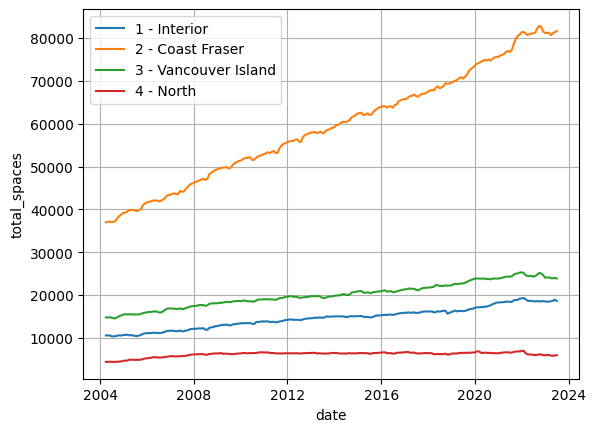

In [66]:
fig, ax = plt.subplots()

temp_df= enhance_facility_df(facility_df=facility_df)
regions = temp_df['region'].unique()
y_col = "total_spaces"

for region in regions:

    region_df = temp_df[temp_df['region'] == region]
    # region_df = region_df.resample('Y',  label='left', closed='right', on='date').max()
    # ax.plot_date(data=region_df, x='date', y=y_col, ls='-', label=region)
    sns.lineplot(data=region_df, x='date', y=y_col, ls='-', label=region)

ax.legend()
ax.grid()

## Spaces: Growth

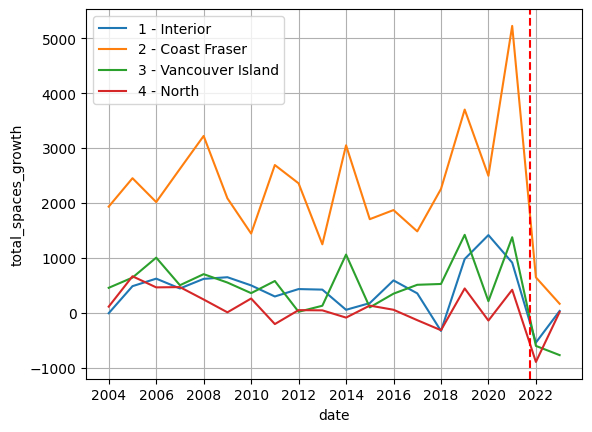

In [67]:
fig, ax = plt.subplots()

temp_df= enhance_facility_df(facility_df=facility_df)
regions = temp_df['region'].unique()
y_col = "total_spaces_growth"

for region in regions[:]:

    region_df = temp_df[temp_df['region'] == region]
    region_df = region_df.resample('Y', on='date',label='left', closed='right').sum()
    # ax.plot_date(data=region_df, x='date', y=y_col, ls='-', label=region)
    sns.lineplot(data=region_df, x='date', y=y_col, ls='-', label=region)

dt_child_care_legn = pd.to_datetime("2021-10")
ax.axvline(dt_child_care_legn, ls='--', color='r')
plt.legend()
plt.grid()

- There have been a significant number of growth maximum number of spaces available on recond for a given year.
- The Coast Fraser region which consits of highly populated and rapidly growing  cities such as langley and Surrey, has experienced the most rapid growth  both in absolute numbers and percentage. 
    - This region has seen a 2X increase in the spaces available for Coast Fraser region
- This is followed at a distance by the Vancouver Island and Interior regions whcih seem to have a similar annula growth pattern, even though there are more spances in the Vancouver island region
- The least growth in see in the norther region
- There has been a 2X increase in the spaces available for Coast Fraser region


Looking at the yearly growth trends:, 
- the sharpest increase in the number of total spaces was recorded between 2021-2022, from about 2500 to over 5000 spaces in 2022
- This peak in 2021 may be linked to the government intervention.
-  [In 2021, the **Childcare BC New Spaces Fund** and the **Canada-B.C. Early Learning and Child Care Agreement** continued to provide funding to create thousands of new licensed child care spaces throughout the province](https://www2.gov.bc.ca/gov/content/family-social-supports/caring-for-young-children/childcarebc-engagement/creating-spaces?keyword=2022), [4](https://www2.gov.bc.ca/gov/content/family-social-supports/caring-for-young-children/childcarebc-engagement/creating-spaces?keyword=2022), [5](https://www2.gov.bc.ca/assets/gov/family-and-social-supports/child-care/running-a-daycare-or-preschool/newspaces_fund_faq.pdf), [6](https://bing.com/search?q=child+care+facility+spaces+growth+BC+2021), [7](https://news.gov.bc.ca/releases/2022ECC0035-000689), [8](https://news.gov.bc.ca/releases/2021CFD0053-001063). This may have boosted the capacity and accessibility of child care facilities in BC.

## Facilities : Total

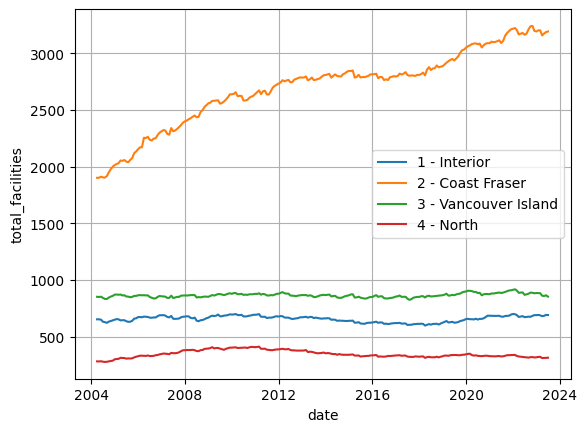

In [68]:
fig, ax = plt.subplots()

temp_df= enhance_facility_df(facility_df=facility_df)
regions = temp_df['region'].unique()
y_col = "total_facilities"

for region in regions:

    region_df = temp_df[temp_df['region'] == region]
    # region_df = region_df.resample('Y',  label='left', closed='right', on='date').max()
    # ax.plot_date(data=region_df, x='date', y=y_col, ls='-', label=region)
    sns.lineplot(data=region_df, x='date', y=y_col, ls='-', label=region)

plt.legend()
plt.grid()

## Facitlties: Growth

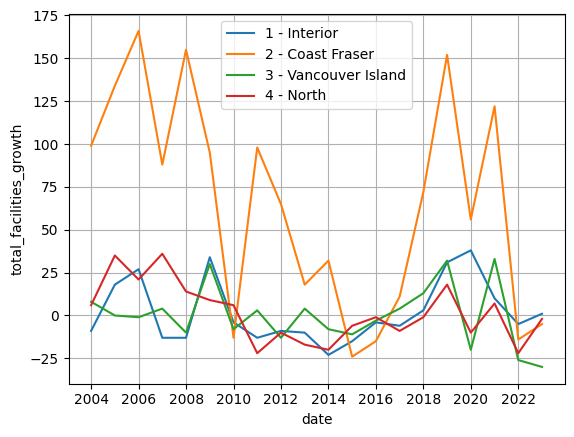

In [69]:
fig, ax = plt.subplots()

temp_df= enhance_facility_df(facility_df=facility_df)
regions = temp_df['region'].unique()
y_col = "total_facilities_growth"

for region in regions[:]:

    region_df = temp_df[temp_df['region'] == region]
    region_df = region_df.resample('Y', on='date',label='left', closed='right').sum()
    # ax.plot_date(data=region_df, x='date', y=y_col, ls='-', label=region)
    sns.lineplot(data=region_df, x='date', y=y_col, ls='-', label=region)

plt.legend()
plt.grid()

-  Again, as expected, the number of facilities has significantly increased in the Coast Fraser regions. 
- This is unlike the other 3 regions which have seen a comparatively non-significant change.
- the growth change curve further mshows that there is a sharp increase in the number of facilities from around 2015 and peaking in 2019
- This period of facility growth may be linked to various government interventions within the same period such as the following:

    - [In 2016, the **federal government** committed to increase its investments to help Canadian children get the best start in life, including $500 million toward establishing a national framework on early learning and child care](https://www.canada.ca/en/employment-social-development/programs/early-learning-child-care/reports/2019-national-progress.html)[1](https://www.canada.ca/en/employment-social-development/programs/early-learning-child-care/reports/2019-national-progress.html).
    - [In 2017, the **ChildCareBC** plan was launched, which aimed to deliver quality and affordable child care to more families in BC, reduce child care fees for parents, build more licensed spaces, and increase supports for those working in the sector](https://www2.gov.bc.ca/gov/content/family-social-supports/caring-for-young-children)[2](https://www2.gov.bc.ca/gov/content/family-social-supports/caring-for-young-children)[3](https://www2.gov.bc.ca/gov/content/family-social-supports/caring-for-young-children/child-care-strategy).
    - [In 2018, the **Canada-B.C. Early Learning and Child Care Agreement** was signed, which provided $153 million over three years to create thousands of new licensed child care spaces throughout the province](https://news.gov.bc.ca/releases/2022ECC0035-000689)[4](https://news.gov.bc.ca/releases/2022ECC0035-000689).

# Facilities Distribution

## Distribution by city

In [70]:
locs_df.head(2)

,FAC_PARTY_ID,SERVICE_TYPE_CD,NAME,ADDRESS_1,ADDRESS_2,CITY,POSTAL_CODE,LATITUDE,LONGITUDE,PHONE,...,ELF_PROGRAMMING_YN,VACANCY_SRVC_UNDER36,VACANCY_SRVC_30MOS_5YRS,VACANCY_SRVC_LICPRE,VACANCY_SRVC_OOS_GR1_AGE12,VACANCY_LAST_UPDATE,HA_FAC_INSPEC_RPTS,IS_INCOMPLETE_IND,IS_CCFRI_AUTH,IS_DUPLICATE
0,1,Licensed Group,Bonnie Bairns Childcare Services,2260 Philip Ave,NaN,North Vancouver,V7P 2W8,49.330395,-123.112745,604-983-2600,...,N,N,Y,N,N,2023/08/01,https://inspections.vcha.ca/ChildCare/Table,N,Y,N
1,2,Licensed Group,Willow Point Children's Centre,200 Larwood Rd,NaN,Campbell River,V9W 2S1,49.967369,-125.216290,250-923-0484,...,N,N,Y,N,Y,2023/08/02,https://www.healthspace.ca/clients/viha/viha_w...,N,Y,N


city_perc    50.552268
dtype: float64


Text(0.5, 1.0, 'Distribution of child care facilities across the cities \n (showing top 10 )')

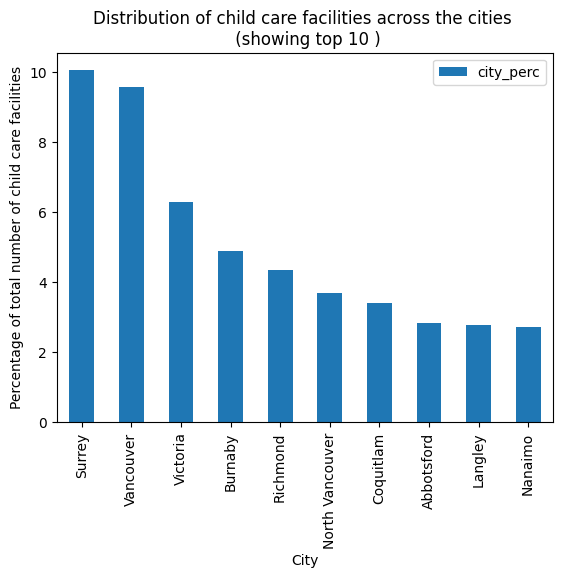

In [71]:
group_col_name = 'CITY'
agg_col_name = 'city_perc'
temp_df = (
    locs_df
    .query("IS_DUPLICATE == 'N'")
    .loc[:, [group_col_name]]
    .groupby(group_col_name).apply(lambda x: x.count() * 100.0 / len(locs_df))
    .rename(columns={group_col_name:agg_col_name})
    .sort_values(by=agg_col_name, ascending=False)
)
n = 10
fig, ax = plt.subplots()
temp_df[:n].plot.bar(ax=ax)
print(temp_df[:n].sum())

ax.set_xlabel('City')
ax.set_ylabel('Percentage of total number of child care facilities');
ax.set_title(f'Distribution of child care facilities across the cities \n (showing top {n} )')

- Vancouver and Surrey each constitue about 10% of child care facilities in BC which is expected given the population density in these cities.

- The first 10 cities shown here constitute about 51% of the child care facilities in BC

## Distribution by region

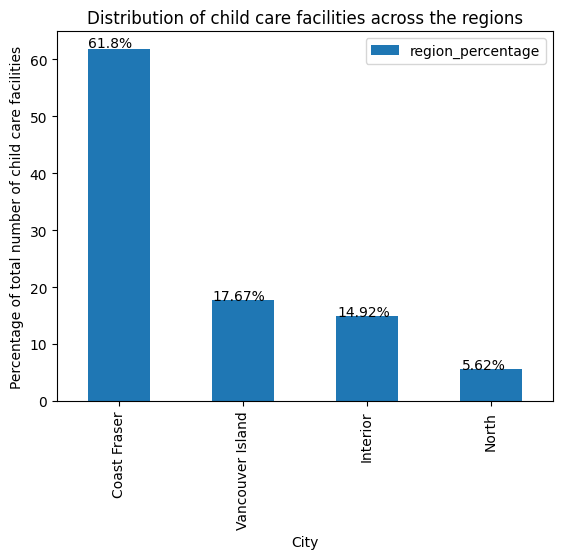

In [72]:
cities_regions_map = C.CITIES_REGIONS_MAP


group_col_name = 'region'
agg_col_name = 'region_percentage'
temp_df = (
    locs_df
    # .assign(region=lambda x: cities_regions_map[x['CITY']])
    .query("IS_DUPLICATE == 'N'")
    .assign(region=locs_df['CITY'].str.lower().apply(lambda x: cities_regions_map.get(x, 'other')))
    .loc[:, [group_col_name]]
    .groupby(group_col_name).apply(lambda x: x.count() * 100.0 / len(locs_df.query("IS_DUPLICATE == 'N'")))
    .rename(columns={group_col_name:agg_col_name})
    .sort_values(by=agg_col_name, ascending=False)
)

n = 10
fig, ax = plt.subplots()
temp_df[:n].plot.bar(ax=ax)

ax.set_xlabel('City')
ax.set_ylabel('Percentage of total number of child care facilities');
ax.set_title(f'Distribution of child care facilities across the regions')

for p in ax.patches:
    ax.annotate(str(round(p.get_height(), 2))+'%', (p.get_x() * 1.005, p.get_height() * 1.005))

- The distribution by region reflects what was observed in the cities. Cities such as Surrey make up the Coast Fraser Region accounting for most (about 61.82%) of the daycare facilities. 